# Multi-State Model - rotterdam example

## In this notebook  

This notebook provides a first example of using the pymsm package, using the rotterdam dataset.

## Rotterdam dataset

The rotterdam data set includes 2982 primary breast cancers patients whose data records were included in the Rotterdam tumor bank. Patients were followed for a time ranging between 1 to 231 months (median 107 months), and outcomes were defined as disease recurrence or death from any cause.  

This data includes 2982 patients, with 15 covariates, and was extracted from R 'survival' package.  
For more information see page 113 in https://cran.r-project.org/web/packages/survival/survival.pdf.

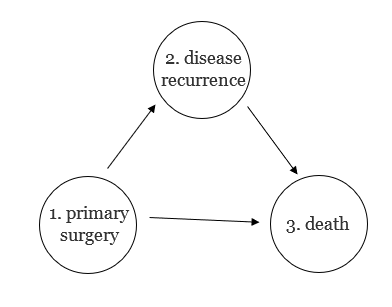

In [1]:
from IPython.display import Image
Image(filename='../src/pymsm/examples/rotterdam_states.png')

Let’s load the dataset, which holds for each patient the transitions between the three states decribed in the above graph

In [2]:
from pymsm.datasets import prep_rotterdam
dataset, states_labels = prep_rotterdam()
print('dataset type: {}'.format(type(dataset)))
print('elemnets type: {}'.format(type(dataset[0])))

dataset type: <class 'list'>
elemnets type: <class 'pymsm.multi_state_competing_risks_model.PathObject'>


The dataset is a list of elements from class PathObject. Each PathObject in the list corresponds to a single sample’s (i.e “patient’s”) observed path.

Let’s look at one such object in detail:

In [3]:
sample_path = dataset[1314]
sample_path.print_path()

Sample id: 1326
States: [1, 2, 3]
Transition times: [873.999987, 1672.0000989999999]
Covariates:
year      1990
age         44
meno         0
grade        3
nodes       17
pgr         40
er           7
hormon       0
chemo        1
Name: 1314, dtype: object


We see the following attributes:

1. *sample_id* : (optional) a unique identifier of the patient.

2. *states* : These are the observed states the sample visited, encoded as positive integers. Here we can see the patient moved from state 1 to 2, ending with the only terminal state (state 3).

3. *time_at_each_state* : These are the observed times spent at each state.

4. *covariates* : These are the patient’s covariates
    * “year”
    * "age"
    * "meno"
    * "grade"
    * "nodes"
    * "pge"
    * "er"
    * "hormone"
    * "chemo"

Note: if the last state is a terminal state, then the vector of times should be shorter than the vector of states by 1. Conversely, if the last state is not a terminal state, then the length of the vector of times should be the same as that of the states. In such a case, the sample is inferred to be right censored.

## Updating Covariates Over Time

In order to update the patient covariates over time, we need to define a state-transition function.
In this simple case, the covariates do not change and the function is trivial

In [4]:
def default_update_covariates_function(covariates_entering_origin_state, origin_state=None, target_state=None,
                                       time_at_origin=None, abs_time_entry_to_target_state=None):
    return covariates_entering_origin_state

You can define any function, as long as it recieves the following parameter types (in this order): 
1. pandas Series (sample covariates when entering the origin state)
2. int (origin state number)
3. int (target state number)
4. float (time spent at origin state)
5. float (absolute time of entry to target state)

If some of the parameters are not used in the function, use a default value of None, as in the example above.

## Defining terminal states

In [5]:
terminal_states = [3]

## Fitting the model

Import and init the model

In [6]:
from pymsm.multi_state_competing_risks_model import MultiStateModel

multi_state_model = MultiStateModel(
    dataset, 
    terminal_states, 
    default_update_covariates_function
)

Fit the model

In [7]:
multi_state_model.fit()

Fitting Model at State: 1
>>> Fitting Transition to State: 3, n events: 195
>>> Fitting Transition to State: 2, n events: 1518
Fitting Model at State: 2
>>> Fitting Transition to State: 3, n events: 1077


## Making predictions  

Predictions are done via monte carlo simulation. Initial patient covariates, along with the patient’s current state are supplied. The next states are sequentially sampled via the model parameters. The process concludes when the patient arrives at a terminal state or the number of transitions exceeds the specified maximum.

In [9]:
import numpy as np

all_mcs = multi_state_model.run_monte_carlo_simulation(
    # the current covariates of the patient.
    # especially important to use updated covariates in case of
    # time varying covariates along with a prediction from a point in time
    # during hospitalization
    sample_covariates=dataset[0].covariates.values,
    # in this setting samples start at state 1, but
    # in general this can be any non-terminal state which
    # then serves as the simulation starting point
    origin_state=1,
    # in this setting we start predictions from time 0, but
    # predictions can be made from any point in time during the
    # patient's trajectory
    current_time=0,
    # If there is an observed upper limit on the number of transitions, we recommend
    # setting this value to that limit in order to prevent generation of outlier paths
    max_transitions=2,
    # the number of paths to simulate:
    n_random_samples=100,
)


100%|██████████| 100/100 [00:31<00:00,  3.16it/s]


## The Simulation Results Format

Each run is described by a list of states and times spent at each state (same format as the dataset the model is fit to).  
Below are two samples:  

In [10]:
mc = all_mcs[0]
print(mc.states)
print(mc.time_at_each_state)

mc = all_mcs[1]
print(mc.states)
print(mc.time_at_each_state)

[1, 2, 3]
[2599.999993942681, 2689.999979057319]
[1, 2, 3]
[5471.999838, 181.0003910000005]
